In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
### Lab PC
# === Load Train and Test Data ===
# train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
# test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")

### LSTM

In [4]:
# ─────── Hyperparameters ───────
SEQ_LEN     = 60        # Length of input sequence (seconds)
BATCH_SIZE  = 64        # Batch size for training
HIDDEN_SIZE = 64        # Number of hidden units in LSTM
NUM_LAYERS  = 2         # Number of LSTM layers
DROPOUT     = 0.3       # Dropout rate between LSTM layers
LR          = 1e-3      # Learning rate for Adam optimizer
MAX_EPOCHS  = 50        # Maximum number of training epochs
PATIENCE    = 10         # Early stopping patience

In [5]:
FEATURES = [
    "Ambient Temp Trace(F)",
    "Inlet Temp Trace(F)",
    "Outlet Temp Trace (F)",
    "Operational Mode Code",
]
TARGET = "Power (W)"

# ─────── Device configuration ───────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────── Load and scale data ───────
#train_df = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Trian\Trian\Merged_HPWH_Train_1s.csv")
#test_df  = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Test\Test\Merged_HPWH_Test_1s.csv")

####Lab PC
train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on the training set and transform both the train and test
X_train = scaler_x.fit_transform(train_df[FEATURES])
y_train = scaler_y.fit_transform(train_df[[TARGET]]).squeeze(-1)
X_test  = scaler_x.transform(test_df[FEATURES])
y_test  = scaler_y.transform(test_df[[TARGET]]).squeeze(-1)

# ─────── Dataset definition ───────
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        # Store as tensors; slicing will happen in __getitem__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # Number of samples is total length minus one sequence
        return self.X.size(0) - self.seq_len

    def __getitem__(self, idx):
        # Return one sequence window and its target value
        x_seq = self.X[idx : idx + self.seq_len]  # Shape: [seq_len, num_features]
        y_val = self.y[idx + self.seq_len]        # Scalar target
        return x_seq, y_val

# Instantiate datasets and loaders
train_ds = SequenceDataset(X_train, y_train, SEQ_LEN)
test_ds  = SequenceDataset(X_test,  y_test,  SEQ_LEN)
print("Train samples:", len(train_ds), "Test samples:", len(test_ds))

Using device: cpu
Train samples: 176281 Test samples: 50281


In [6]:
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True
)

# ─────── Model definition ───────
class HPWH_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        # Stacked LSTM with dropout between layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # Final linear layer to map hidden state to output
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch, seq_len, features]
        _, (h_n, _) = self.lstm(x)
        # Use the last layer's final hidden state
        out = self.fc(h_n[-1])
        return out.squeeze(-1)  # Shape: [batch]

# Create model, loss, and optimizer
model = HPWH_LSTM(
    input_size=len(FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ─────── Training loop with early stopping ───────
best_val_loss = float("inf")
no_improve    = 0

for epoch in range(1, MAX_EPOCHS + 1):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{MAX_EPOCHS}", leave=False)
    for Xb, yb in loop:
        # Move batch to the correct device
        Xb, yb = Xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
        loop.set_postfix(loss=loss.item())
    train_loss /= len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            preds = model(Xb)
            val_loss += criterion(preds, yb).item() * Xb.size(0)
    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.5f} | Val MSE: {val_loss:.5f}")
        # ---- Early stopping check ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_hpwh_lstm.pt")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs).")
            break

Epoch 01 | Train MSE: 0.02710 | Val MSE: 0.06904


Epoch 02 | Train MSE: 0.03182 | Val MSE: 0.04655


Epoch 03 | Train MSE: 0.03241 | Val MSE: 0.04580


Epoch 04 | Train MSE: 0.02848 | Val MSE: 0.06415


Epoch 05 | Train MSE: 0.02525 | Val MSE: 0.08453


Epoch 06 | Train MSE: 0.02964 | Val MSE: 0.04628


Epoch 07 | Train MSE: 0.02617 | Val MSE: 0.04867


Epoch 08 | Train MSE: 0.02132 | Val MSE: 0.06575


Epoch 09 | Train MSE: 0.01710 | Val MSE: 0.07549


Epoch 10 | Train MSE: 0.01359 | Val MSE: 0.11543


Epoch 11 | Train MSE: 0.01575 | Val MSE: 0.09980


Epoch 12 | Train MSE: 0.01365 | Val MSE: 0.06503


Epoch 13 | Train MSE: 0.00785 | Val MSE: 0.05542
Early stopping at epoch 13 (no improvement for 10 epochs).



Test MAE: 33.98 W | RMSE: 55.87 W


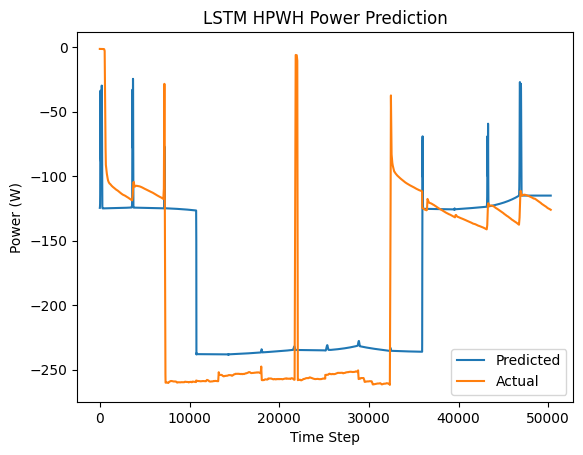

In [7]:
# ─────── Load best model & evaluate ───────
model.load_state_dict(torch.load("best_hpwh_lstm.pt"))
model.eval()

y_true_list, y_pred_list = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()  # Move to CPU before converting
        y_true_list.append(yb.numpy())
        y_pred_list.append(preds)

# Concatenate batches and inverse-transform
y_true_scaled = np.concatenate(y_true_list).reshape(-1, 1)
y_pred_scaled = np.concatenate(y_pred_list).reshape(-1, 1)

y_true = scaler_y.inverse_transform(y_true_scaled).ravel()
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"\nTest MAE: {mae:.2f} W | RMSE: {rmse:.2f} W")

# ─────── Plot predictions vs. actual ───────
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_pred, label="Predicted")
plt.plot(y_true, label="Actual")
plt.legend()
plt.title("LSTM HPWH Power Prediction")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.show()

### Capture Spike -LSTM

Using device: cpu
Detected 6 spike samples out of 176341 total.


Epoch 01 | Train W-MSE: 0.02861 | Val MSE: 0.05238


Epoch 02 | Train W-MSE: 0.02112 | Val MSE: 0.07615


Epoch 03 | Train W-MSE: 0.01647 | Val MSE: 0.06680


Epoch 04 | Train W-MSE: 0.01382 | Val MSE: 0.12528


Epoch 05 | Train W-MSE: 0.02084 | Val MSE: 0.11471


Epoch 06 | Train W-MSE: 0.01353 | Val MSE: 0.06103


Epoch 07 | Train W-MSE: 0.01499 | Val MSE: 0.06552


Epoch 08 | Train W-MSE: 0.01019 | Val MSE: 0.07662


Epoch 09 | Train W-MSE: 0.01411 | Val MSE: 0.10958


Epoch 10 | Train W-MSE: 0.00697 | Val MSE: 0.09716


Epoch 11 | Train W-MSE: 0.00783 | Val MSE: 0.09143
Early stopping at epoch 11.

Final Test MAE: 33.59 W | RMSE: 59.75 W


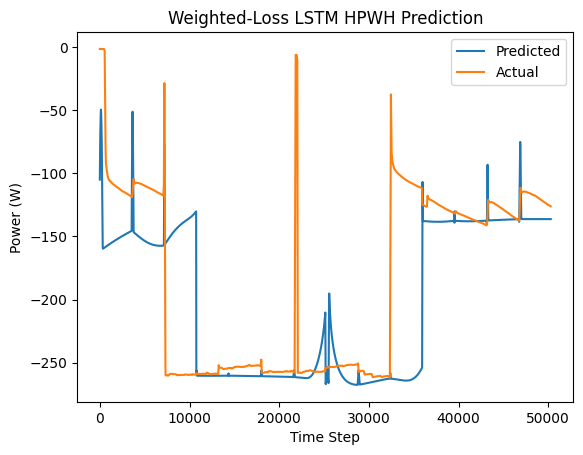

In [8]:
# hpwh_lstm_weighted_spikes_full.py

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# ───── Hyperparameters ─────
SEQ_LEN      = 60        # Number of time steps per sample
BATCH_SIZE   = 64
HIDDEN_SIZE  = 64
NUM_LAYERS   = 2
DROPOUT      = 0.3
LR           = 1e-3
MAX_EPOCHS   = 50
PATIENCE     = 10
SPIKE_WEIGHT = 5.0       # Weight multiplier for spike samples
SPIKE_K      = 6     # Threshold: |Δy| > K * std(Δy) marks a spike

FEATURES = [
    "Ambient Temp Trace(F)",
    "Inlet Temp Trace(F)",
    "Outlet Temp Trace (F)",
    "Operational Mode Code",
]
TARGET = "Power (W)"

# ───── Device configuration ─────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ───── Load & normalize data ─────
##Home PC
#train_df = pd.read_csv( r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Trian\Trian\Merged_HPWH_Train_1s.csv")
#test_df = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Test\Test\Merged_HPWH_Test_1s.csv")

####Lab PC
train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(train_df[FEATURES])
y_train = scaler_y.fit_transform(train_df[[TARGET]]).ravel()
X_test  = scaler_x.transform(test_df[FEATURES])
y_test  = scaler_y.transform(test_df[[TARGET]]).ravel()

# ───── Detect spikes events & assign weights ─────
# Compute absolute first-differences
dy = np.abs(np.diff(y_train, prepend=y_train[0]))
threshold = SPIKE_K * np.std(dy)
is_spike = (dy > threshold).astype(float)
print(f"Detected {int(is_spike.sum())} spike samples out of {len(is_spike)} total.")

# Build per-sample weight vector
weights = np.where(is_spike > 0, SPIKE_WEIGHT, 1.0)

# ─────Dataset definition ─────
class SequenceDataset(Dataset):
    def __init__(self, X, y, w, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.w = torch.tensor(w, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]    # [seq_len, features]
        y_val = self.y[idx + self.seq_len]          # scalar target
        w_val = self.w[idx + self.seq_len]          # scalar weight
        return x_seq, y_val, w_val

train_ds = SequenceDataset(X_train, y_train, weights, SEQ_LEN)
test_ds  = SequenceDataset(X_test,  y_test,  np.ones_like(y_test), SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# ─────LSTM model ─────
class HPWH_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, features]
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out.squeeze(-1)  # [batch]

model = HPWH_LSTM(
    input_size=len(FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# ───── Weighted MSE loss ─────
def weighted_mse(pred, target, weight):
    return torch.mean(weight * (pred - target) ** 2)

optimizer = optim.Adam(model.parameters(), lr=LR)

# ───── Training loop with early stopping ─────
best_val_loss = float("inf")
wait = 0

for epoch in range(1, MAX_EPOCHS + 1):
    # -- train --
    model.train()
    train_loss = 0.0
    for Xb, yb, wb in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        Xb, yb, wb = Xb.to(device), yb.to(device), wb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = weighted_mse(preds, yb, wb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # -- validate (unweighted MSE) --
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb, _ in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            val_loss += nn.MSELoss()(preds, yb).item() * Xb.size(0)
    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch:02d} | Train W-MSE: {train_loss:.5f} | Val MSE: {val_loss:.5f}")

    # early stopping on validation MSE
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_weighted_lstm.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch}.")
            break

# ───── Load best model & final evaluation ─────
model.load_state_dict(torch.load("best_weighted_lstm.pt"))
model.eval()

y_true_list, y_pred_list = [], []
with torch.no_grad():
    for Xb, yb, _ in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).cpu().numpy()
        y_true_list.append(yb.numpy())
        y_pred_list.append(preds)

y_true = scaler_y.inverse_transform(
    np.concatenate(y_true_list).reshape(-1, 1)
).ravel()
y_pred = scaler_y.inverse_transform(
    np.concatenate(y_pred_list).reshape(-1, 1)
).ravel()

mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"\nFinal Test MAE: {mae:.2f} W | RMSE: {rmse:.2f} W")

# ───── Plot predicted vs. actual ─────
plt.figure()
plt.plot(y_pred, label="Predicted")
plt.plot(y_true, label="Actual")
plt.legend()
plt.title("Weighted-Loss LSTM HPWH Prediction")
plt.xlabel("Time Step")
plt.ylabel("Power (W)")
plt.show()

### GRU

Using device: cpu


[GRU] Epoch 01 | Train MSE: 0.02687 | Val MSE: 0.06185


[GRU] Epoch 02 | Train MSE: 0.01265 | Val MSE: 0.07790


[GRU] Epoch 03 | Train MSE: 0.01113 | Val MSE: 0.08698


[GRU] Epoch 04 | Train MSE: 0.00847 | Val MSE: 0.08092


[GRU] Epoch 05 | Train MSE: 0.00688 | Val MSE: 0.09687


[GRU] Epoch 06 | Train MSE: 0.00540 | Val MSE: 0.09048


[GRU] Epoch 07 | Train MSE: 0.00537 | Val MSE: 0.13256


[GRU] Epoch 08 | Train MSE: 0.00542 | Val MSE: 0.10292


[GRU] Epoch 09 | Train MSE: 0.00501 | Val MSE: 0.11691


[GRU] Epoch 10 | Train MSE: 0.00428 | Val MSE: 0.11113


[GRU] Epoch 11 | Train MSE: 0.00476 | Val MSE: 0.12353
Early stopping GRU.
GRU Test MAE: 38.26 W | RMSE: 64.92 W


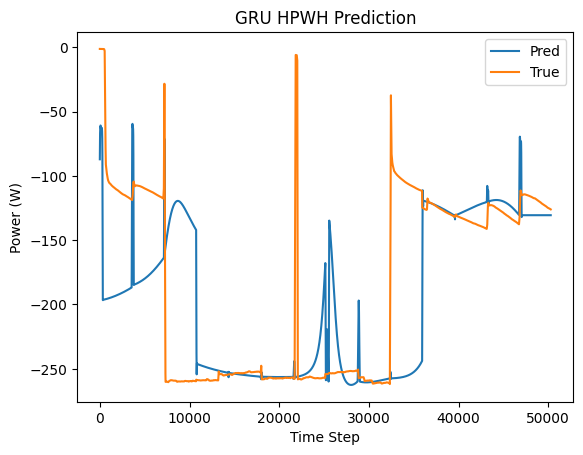

In [9]:
# hpwh_gru.py

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# ───── Hyperparameters ─────
SEQ_LEN     = 60
BATCH_SIZE  = 64
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.3
LR          = 1e-3
MAX_EPOCHS  = 50
PATIENCE    = 10

FEATURES = [
    "Ambient Temp Trace(F)",
    "Inlet Temp Trace(F)",
    "Outlet Temp Trace (F)",
    "Operational Mode Code",
]
TARGET = "Power (W)"

# ───── Device ─────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ───── Load & Scale ─────
####Lab PC
train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")

#train_df = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Trian\Trian\Merged_HPWH_Train_1s.csv")
#test_df  = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Test\Test\Merged_HPWH_Test_1s.csv")

scaler_x = MinMaxScaler(); scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(train_df[FEATURES])
y_train = scaler_y.fit_transform(train_df[[TARGET]]).squeeze(-1)
X_test  = scaler_x.transform(test_df[FEATURES])
y_test  = scaler_y.transform(test_df[[TARGET]]).squeeze(-1)

# ───── Dataset ─────
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len
    def __len__(self):
        return self.X.size(0) - self.seq_len
    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],   # [seq_len, features]
            self.y[idx+self.seq_len]        # scalar
        )

train_ds = SequenceDataset(X_train, y_train, SEQ_LEN)
test_ds  = SequenceDataset(X_test,  y_test,  SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# ───── Model ─────
class HPWH_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(
            input_size, hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: [batch, seq_len, features]
        _, h_n = self.gru(x)
        # h_n: [num_layers, batch, hidden_size]
        out = self.fc(h_n[-1])           # use last layer
        return out.squeeze(-1)           # [batch]

model = HPWH_GRU(
    input_size=len(FEATURES),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ───── Training Loop ─────
best_val = float('inf'); wait = 0
for epoch in range(1, MAX_EPOCHS+1):
    model.train(); train_loss = 0.
    for Xb, yb in tqdm(train_loader, desc=f"GRU Epoch {epoch}/{MAX_EPOCHS}", leave=False):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss  = criterion(preds, yb)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval(); val_loss = 0.
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            val_loss += criterion(model(Xb), yb).item() * Xb.size(0)
    val_loss /= len(test_loader.dataset)

    print(f"[GRU] Epoch {epoch:02d} | Train MSE: {train_loss:.5f} | Val MSE: {val_loss:.5f}")
    if val_loss < best_val:
        best_val = val_loss; wait = 0
        torch.save(model.state_dict(), "best_gru.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping GRU.")
            break

# ───── Evaluate ─────
model.load_state_dict(torch.load("best_gru.pt"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        out = model(Xb).cpu().numpy()
        y_pred.append(out); y_true.append(yb.numpy())
y_true = scaler_y.inverse_transform(np.concatenate(y_true).reshape(-1,1)).ravel()
y_pred = scaler_y.inverse_transform(np.concatenate(y_pred).reshape(-1,1)).ravel()
mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"GRU Test MAE: {mae:.2f} W | RMSE: {rmse:.2f} W")

# ───── Plot ─────
plt.figure()
plt.plot(y_pred, label="Pred")
plt.plot(y_true, label="True")
plt.title("GRU HPWH Prediction")
plt.xlabel("Time Step"); plt.ylabel("Power (W)")
plt.legend(); plt.show()


### 1D_CNN

[CNN] Ep01 Train MSE:0.02331 Val MSE:0.08152


[CNN] Ep02 Train MSE:0.01106 Val MSE:0.11838


[CNN] Ep03 Train MSE:0.00921 Val MSE:0.12839


[CNN] Ep04 Train MSE:0.00847 Val MSE:0.13797


[CNN] Ep05 Train MSE:0.00822 Val MSE:0.08887


[CNN] Ep06 Train MSE:0.00794 Val MSE:0.14934


[CNN] Ep07 Train MSE:0.00769 Val MSE:1.39833


[CNN] Ep08 Train MSE:0.00751 Val MSE:5.03997


[CNN] Ep09 Train MSE:0.00737 Val MSE:11.55187


[CNN] Ep10 Train MSE:0.00715 Val MSE:23.69240


[CNN] Ep11 Train MSE:0.00707 Val MSE:31.12496
Early stopping CNN.
CNN Test MAE:38.26 W RMSE:64.92 W


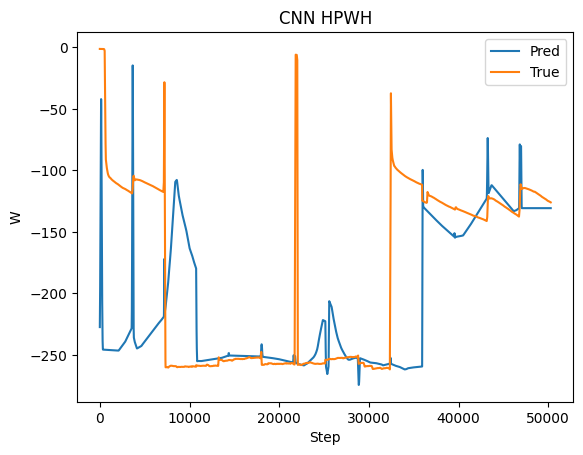

In [10]:
# hpwh_cnn.py

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# ───── Hyperparameters ─────
SEQ_LEN     = 60
BATCH_SIZE  = 64
NUM_FILTERS = 64
KERNEL_SIZE = 3
DROPOUT     = 0.3
LR          = 1e-3
MAX_EPOCHS  = 50
PATIENCE    = 10

FEATURES = [
    "Ambient Temp Trace(F)",
    "Inlet Temp Trace(F)",
    "Outlet Temp Trace (F)",
    "Operational Mode Code",
]
TARGET = "Power (W)"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───── Load & Scale ─────
#train_df = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Trian\Trian\Merged_HPWH_Train_1s.csv")
#test_df  = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Test\Test\Merged_HPWH_Test_1s.csv")
####Lab PC
train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")
scaler_x = MinMaxScaler(); scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(train_df[FEATURES])
y_train = scaler_y.fit_transform(train_df[[TARGET]]).squeeze(-1)
X_test  = scaler_x.transform(test_df[FEATURES])
y_test  = scaler_y.transform(test_df[[TARGET]]).squeeze(-1)

# ───── Dataset ─────
class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len
    def __len__(self):
        return self.X.size(0) - self.seq_len
    def __getitem__(self, idx):
        # CNN expects [batch, channels, seq_len]
        x = self.X[idx:idx+self.seq_len].transpose(0,1)  # [features, seq_len]
        y = self.y[idx+self.seq_len]
        return x, y

train_dl = DataLoader(SeqDataset(X_train,y_train,SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dl  = DataLoader(SeqDataset(X_test,y_test,SEQ_LEN),  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# ───── Model ─────
class HPWH_CNN(nn.Module):
    def __init__(self, in_channels, num_filters, kernel_size, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, num_filters, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=kernel_size//2)
        self.pool  = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc    = nn.Linear(num_filters, 1)
    def forward(self, x):
        # x: [batch, features, seq_len]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # [batch, num_filters]
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

model = HPWH_CNN(
    in_channels=len(FEATURES),
    num_filters=NUM_FILTERS,
    kernel_size=KERNEL_SIZE,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ───── Train & Early Stop ─────
best_val, wait = float('inf'), 0
for epoch in range(1, MAX_EPOCHS+1):
    model.train(); tloss=0.
    for Xb, yb in tqdm(train_dl, desc=f"CNN Ep {epoch}", leave=False):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss=criterion(out,yb)
        loss.backward(); optimizer.step()
        tloss+=loss.item()*Xb.size(0)
    tloss/=len(train_dl.dataset)

    model.eval(); vloss=0.
    with torch.no_grad():
        for Xb,yb in test_dl:
            Xb,yb=Xb.to(device),yb.to(device)
            vloss+=criterion(model(Xb),yb).item()*Xb.size(0)
    vloss/=len(test_dl.dataset)

    print(f"[CNN] Ep{epoch:02d} Train MSE:{tloss:.5f} Val MSE:{vloss:.5f}")
    if vloss<best_val: best_val,wait=vloss,0; torch.save(model.state_dict(),"best_cnn.pt")
    else:
        wait+=1
        if wait>=PATIENCE:
            print("Early stopping CNN."); break

# ───── Evaluate ─────
model.load_state_dict(torch.load("best_cnn.pt")); model.eval()
yt,yp=[],[]
with torch.no_grad():
    for Xb,yb in test_dl:
        out = model(Xb.to(device)).cpu().numpy()
        yp.append(out); yt.append(yb.numpy())
yt = scaler_y.inverse_transform(np.concatenate(yt).reshape(-1,1)).ravel()
yp = scaler_y.inverse_transform(np.concatenate(yp).reshape(-1,1)).ravel()
mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"CNN Test MAE:{mae:.2f} W RMSE:{rmse:.2f} W")

plt.figure(); plt.plot(yp,label="Pred"); plt.plot(yt,label="True")
plt.title("CNN HPWH"); plt.xlabel("Step"); plt.ylabel("W"); plt.legend(); plt.show()


### Transformer

[Trans] Ep01 Train MSE:0.02453 Val MSE:0.07356


[Trans] Ep02 Train MSE:0.01348 Val MSE:0.06044


[Trans] Ep03 Train MSE:0.01093 Val MSE:0.09781


[Trans] Ep04 Train MSE:0.00965 Val MSE:0.09558


[Trans] Ep05 Train MSE:0.00826 Val MSE:0.09500


[Trans] Ep06 Train MSE:0.00819 Val MSE:0.10781


[Trans] Ep07 Train MSE:0.00670 Val MSE:0.10183


[Trans] Ep08 Train MSE:0.00617 Val MSE:0.11668


[Trans] Ep09 Train MSE:0.00543 Val MSE:0.10997
Early stopping Transformer.
Trans Test MAE:38.26 W RMSE:64.92 W


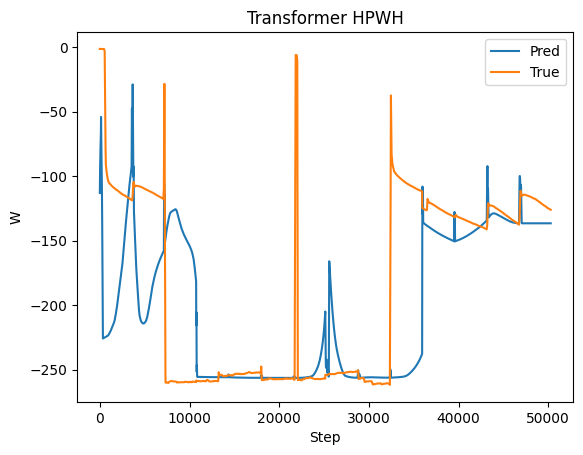

In [11]:
# hpwh_transformer.py

import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# ───── Hyperparams ─────
SEQ_LEN     = 60
BATCH_SIZE  = 64
D_MODEL     = 64    # embedding dim
N_HEAD      = 4
NUM_LAYERS  = 2
DIM_FF      = 128
DROPOUT     = 0.2
LR          = 1e-3
MAX_EPOCHS  = 50
PATIENCE    = 7

FEATURES = [
    "Ambient Temp Trace(F)",
    "Inlet Temp Trace(F)",
    "Outlet Temp Trace (F)",
    "Operational Mode Code",
]
TARGET = "Power (W)"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───── Load & Scale ─────
####Lab PC
train_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Train\Train\Merged_HPWH_Train_1s.csv")
test_df = pd.read_csv(r"C:\Users\jliu359\Downloads\Hpwh\Test\Test\Merged_HPWH_Test_1s.csv")
#train_df = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Trian\Trian\Merged_HPWH_Train_1s.csv")
#test_df  = pd.read_csv(r"C:\Users\default.DESKTOP-C4C7JDR\Downloads\Test\Test\Merged_HPWH_Test_1s.csv")

scaler_x = MinMaxScaler(); scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(train_df[FEATURES])
y_train = scaler_y.fit_transform(train_df[[TARGET]]).squeeze(-1)
X_test  = scaler_x.transform(test_df[FEATURES])
y_test  = scaler_y.transform(test_df[[TARGET]]).squeeze(-1)

# ───── Dataset ─────
class SeqDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len
    def __len__(self):
        return self.X.size(0)-self.seq_len
    def __getitem__(self, idx):
        # [seq_len, features]
        return self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len]

train_dl = DataLoader(SeqDataset(X_train,y_train,SEQ_LEN), batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dl  = DataLoader(SeqDataset(X_test,y_test,SEQ_LEN),  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# ───── Positional Encoding ─────
class PosEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model,2)*(-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.pe = pe.unsqueeze(0)  # [1,max_len,d_model]
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        return x + self.pe[:,:x.size(1),:].to(x.device)

# ───── Model ─────
class HPWH_Transformer(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers, dim_ff, dropout):
        super().__init__()
        self.input_proj = nn.Linear(feature_size, d_model)
        self.pos_enc    = PosEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)
    def forward(self, x):
        # x: [batch, seq_len, features]
        x = self.input_proj(x)            # → [batch, seq_len, d_model]
        x = self.pos_enc(x)
        x = self.transformer(x)           # → [batch, seq_len, d_model]
        out = self.fc(x[:,-1,:])          # take last time step
        return out.squeeze(-1)

model = HPWH_Transformer(
    feature_size=len(FEATURES),
    d_model=D_MODEL,
    nhead=N_HEAD,
    num_layers=NUM_LAYERS,
    dim_ff=DIM_FF,
    dropout=DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ───── Train & Early Stop ─────
best_val, wait = float('inf'), 0
for epoch in range(1, MAX_EPOCHS+1):
    model.train(); tloss=0.
    for Xb,yb in tqdm(train_dl, desc=f"Trans Ep{epoch}", leave=False):
        Xb,yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss=criterion(out,yb)
        loss.backward(); optimizer.step()
        tloss+=loss.item()*Xb.size(0)
    tloss/=len(train_dl.dataset)

    model.eval(); vloss=0.
    with torch.no_grad():
        for Xb,yb in test_dl:
            Xb,yb = Xb.to(device), yb.to(device)
            vloss+=criterion(model(Xb),yb).item()*Xb.size(0)
    vloss/=len(test_dl.dataset)

    print(f"[Trans] Ep{epoch:02d} Train MSE:{tloss:.5f} Val MSE:{vloss:.5f}")
    if vloss<best_val: best_val,wait=vloss,0; torch.save(model.state_dict(),"best_trans.pt")
    else:
        wait+=1
        if wait>=PATIENCE:
            print("Early stopping Transformer."); break

# ───── Evaluate ─────
model.load_state_dict(torch.load("best_trans.pt")); model.eval()
yt,yp=[],[]
with torch.no_grad():
    for Xb,yb in test_dl:
        out = model(Xb.to(device)).cpu().numpy()
        yp.append(out); yt.append(yb.numpy())
yt = scaler_y.inverse_transform(np.concatenate(yt).reshape(-1,1)).ravel()
yp = scaler_y.inverse_transform(np.concatenate(yp).reshape(-1,1)).ravel()
mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Trans Test MAE:{mae:.2f} W RMSE:{rmse:.2f} W")

plt.figure(); plt.plot(yp,label="Pred"); plt.plot(yt,label="True")
plt.title("Transformer HPWH"); plt.xlabel("Step"); plt.ylabel("W"); plt.legend(); plt.show()
